In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import collections
import itertools
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as spio
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from six.moves import urllib

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets('mnits_data/')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnits_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnits_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnits_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnits_data/t10k-labels-idx1-ubyte.gz


In [4]:
def display_digit(digit):
  plt.imshow(digit.reshape(28,28),cmap='Greys',interpolation='nearest')

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


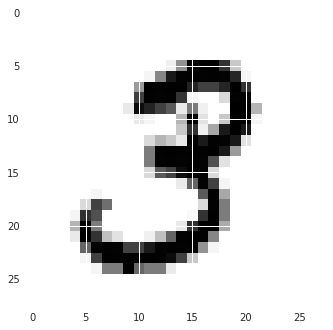

In [5]:
display_digit(mnist.train.images[1])

In [6]:
height = 28
width = 28
channels = 1
n_inputs = height * width

In [7]:
conv1_feature_maps = 32
conv1_kernel_size = 3
conv1_stride = 1
conv1_pad = 'SAME'

In [8]:
conv2_feature_maps = 64
conv2_kernel_size = 3
conv2_stride = 2
conv2_pad = 'SAME'

In [9]:
pool3_feature_maps = conv2_feature_maps

In [11]:
n_fullyconn1 = 64
n_outputs = 10

In [13]:
def build_cnn(features):
  X = tf.reshape(features['images'], shape=[-1,height,width,channels])
  conv1 = tf.layers.conv2d(X, filters=conv1_feature_maps, kernel_size=conv1_kernel_size, strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu)
  conv2 = tf.layers.conv2d(X, filters=conv2_feature_maps, kernel_size=conv2_kernel_size, strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu)
  pool3 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1],padding='VALID')
  pool3_flat = tf.reshape(pool3, shape=[-1, pool3_feature_maps*7*7])
  fullyconn1 = tf.layers.dense(pool3_flat, n_fullyconn1, activation=tf.nn.relu, name='fc1')
  logits = tf.layers.dense(fullyconn1, n_outputs)
  return logits

In [14]:
def cnn_model_fn(features, labels, mode):
  logits = build_cnn(features)
  predicted_classes = tf.argmax(logits, axis=1)
  # prediction
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode, predictions=predicted_classes)
  # training
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
  if mode == tf.estimator.ModeKeys.TRAIN:
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
  # evaluation
  accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_classes)
  return tf.estimator.EstimatorSpec(mode=mode, predictions=predicted_classes, train_op=train_op, loss=loss, eval_metric_ops={'accuracy': accuracy}) 

In [15]:
num_steps = 2000
batch_size = 100

In [16]:
model = tf.estimator.Estimator(cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4cdb537490>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmp4jSaOi', '_save_summary_steps': 100}


In [17]:
input_fn = tf.estimator.inputs.numpy_input_fn(
  x={'images':mnist.train.images},
  y=mnist.train.labels,
  batch_size=batch_size,
  num_epochs=None,
  shuffle=True
)

In [ ]:
model.train(input_fn, steps=num_steps)